In [1]:

# Please note that block size = 512B (as per blktrace)



# Blktrace gets its data from the Linux kernel which considers sectors to be 512 bytes long.
# So I think that, regardless of the device physical sector size,
# blktrace displays offsets and sizes in 512-bytes sectors.


# Since default linux block size = 4096, so blktrace works in multiples of 8 blocks at a time (512*8)






In [2]:
import math

def count_blocks(data):
    block_counter_dict = {}
    for row in data.itertuples():
        
#         print (type(row.PID))
#         if (isinstance(row.PID, float) and not math.isnan(row.PID)):
        process_id = int(row.PID)

        # Trace event PID will be greater than 2000, ignore others
        if process_id > 2000:

            if (row.Start_Block.isdigit()):
                start_block = int(row.Start_Block)
            else:
                continue

            # using offset iterate over the next blocks
            if (math.isnan(row.Number_of_Blocks)):
                next_blocks_count = 0
            else:
                next_blocks_count = int(row.Number_of_Blocks)

            # Incrememnt next blocks counter
            for i in range(0, next_blocks_count):
                if (start_block+i in block_counter_dict):
                    block_counter_dict[start_block+i] += 1
                else:
                    block_counter_dict[start_block+i] = 1
                    
    return block_counter_dict

In [6]:
trace_file = 'varmail_1_cleaned.txt'

trace_file_csv = 'extracted_varmail_15mins.csv'

# Load Trace File  and generate csv

In [7]:
import sys
import csv
import re

listOfData = []

with open(trace_file) as f:
    print ("yes")
    for line in f:
#         print (line)
#         new_line = line.split(' ')
        listOfData.append([line])
# print (listOfData[100].split(' '))


print (len(listOfData))

x = listOfData[5000][0]
print(x)
# # y = re.split("[%D] [%2c] [%8s] [%5T.%9t] [%5p] [%2a] [%3d]", x)
# y = x.extract(" ")
# # y = x.split()
# print (y)



list_of_list = []

for i in listOfData:
    strr = i[0]
    split_str = strr.split()
    list_of_list.append(split_str)
    
print(list_of_list[5000])

yes
660903
  8,6    6     3794    19.169254110   294  D  WS 1393664848 + 8 [kworker/6:1H]

['8,6', '6', '3794', '19.169254110', '294', 'D', 'WS', '1393664848', '+', '8', '[kworker/6:1H]']


In [8]:
with open(trace_file_csv, 'w') as out_file:
    writer = csv.writer(out_file)
#     writer.writerow(('Dev <mjr, mnr>', 'CPU', 'Sequence_Number', 'Timestamp', 'PID', 'Event', 'Activity', 'Start_Block', '+', 'Number_of_Blocks', 'Process'))
    writer.writerows(list_of_list)

# print listOfData

In [9]:
import pandas as pd


# data = pd.read_csv('extracted.csv')

data = pd.read_csv(trace_file_csv, names=['Dev <mjr, mnr>', 'CPU', 'Sequence_Number', 'Timestamp', 'PID', 'Event', 'Activity', 'Start_Block', '+', 'Number_of_Blocks', 'Process'])
data[:100]
# data.shape

,"Dev <mjr, mnr>",CPU,Sequence_Number,Timestamp,PID,Event,Activity,Start_Block,+,Number_of_Blocks,Process
0,"8,6",7,1,0.000000,8395,I,WM,833517664,+,8.0,[kworker/u16:1]
1,"8,6",7,2,0.000001,8395,I,WM,1026455688,+,8.0,[kworker/u16:1]
2,"8,6",7,3,0.000002,8395,I,WM,1026455808,+,8.0,[kworker/u16:1]
3,"8,6",7,4,0.000002,8395,I,WM,1026455944,+,8.0,[kworker/u16:1]
4,"8,6",7,5,0.000002,8395,I,WM,1026461608,+,16.0,[kworker/u16:1]
...,...,...,...,...,...,...,...,...,...,...,...
95,"8,6",6,64,11.204400,294,D,FN,[kworker/6:1H],NaN,NaN,NaN
96,"8,6",6,65,11.204403,294,R,FN,0,[0],NaN,NaN
97,"8,6",6,66,11.204417,8437,C,WS,1266353328,+,40.0,[0]
98,"8,6",6,67,11.204441,294,D,FN,[kworker/6:1H],NaN,NaN,NaN


# Block trace analysis

In [10]:
block_counter_dict = count_blocks(data)


print ("Number of blocks accessed", len(block_counter_dict))
print ("Sum of all the block accesses", sum(block_counter_dict.values()))

Number of blocks accessed 856584
Sum of all the block accesses 2690464


In [6]:
# print(sorted(block_counter_dict.values(), reverse=True))

In [11]:
import collections

sorted_block_counter_dict = collections.OrderedDict(sorted(block_counter_dict.items()))

In [12]:

sorted_df = pd.DataFrame.from_dict(sorted_block_counter_dict, orient='index')

print(sorted_df)

             0
833517568   38
833517569   38
833517570   38
833517571   38
833517572   38
...         ..
1597253627   2
1597253628   2
1597253629   2
1597253630   2
1597253631   2

[856584 rows x 1 columns]


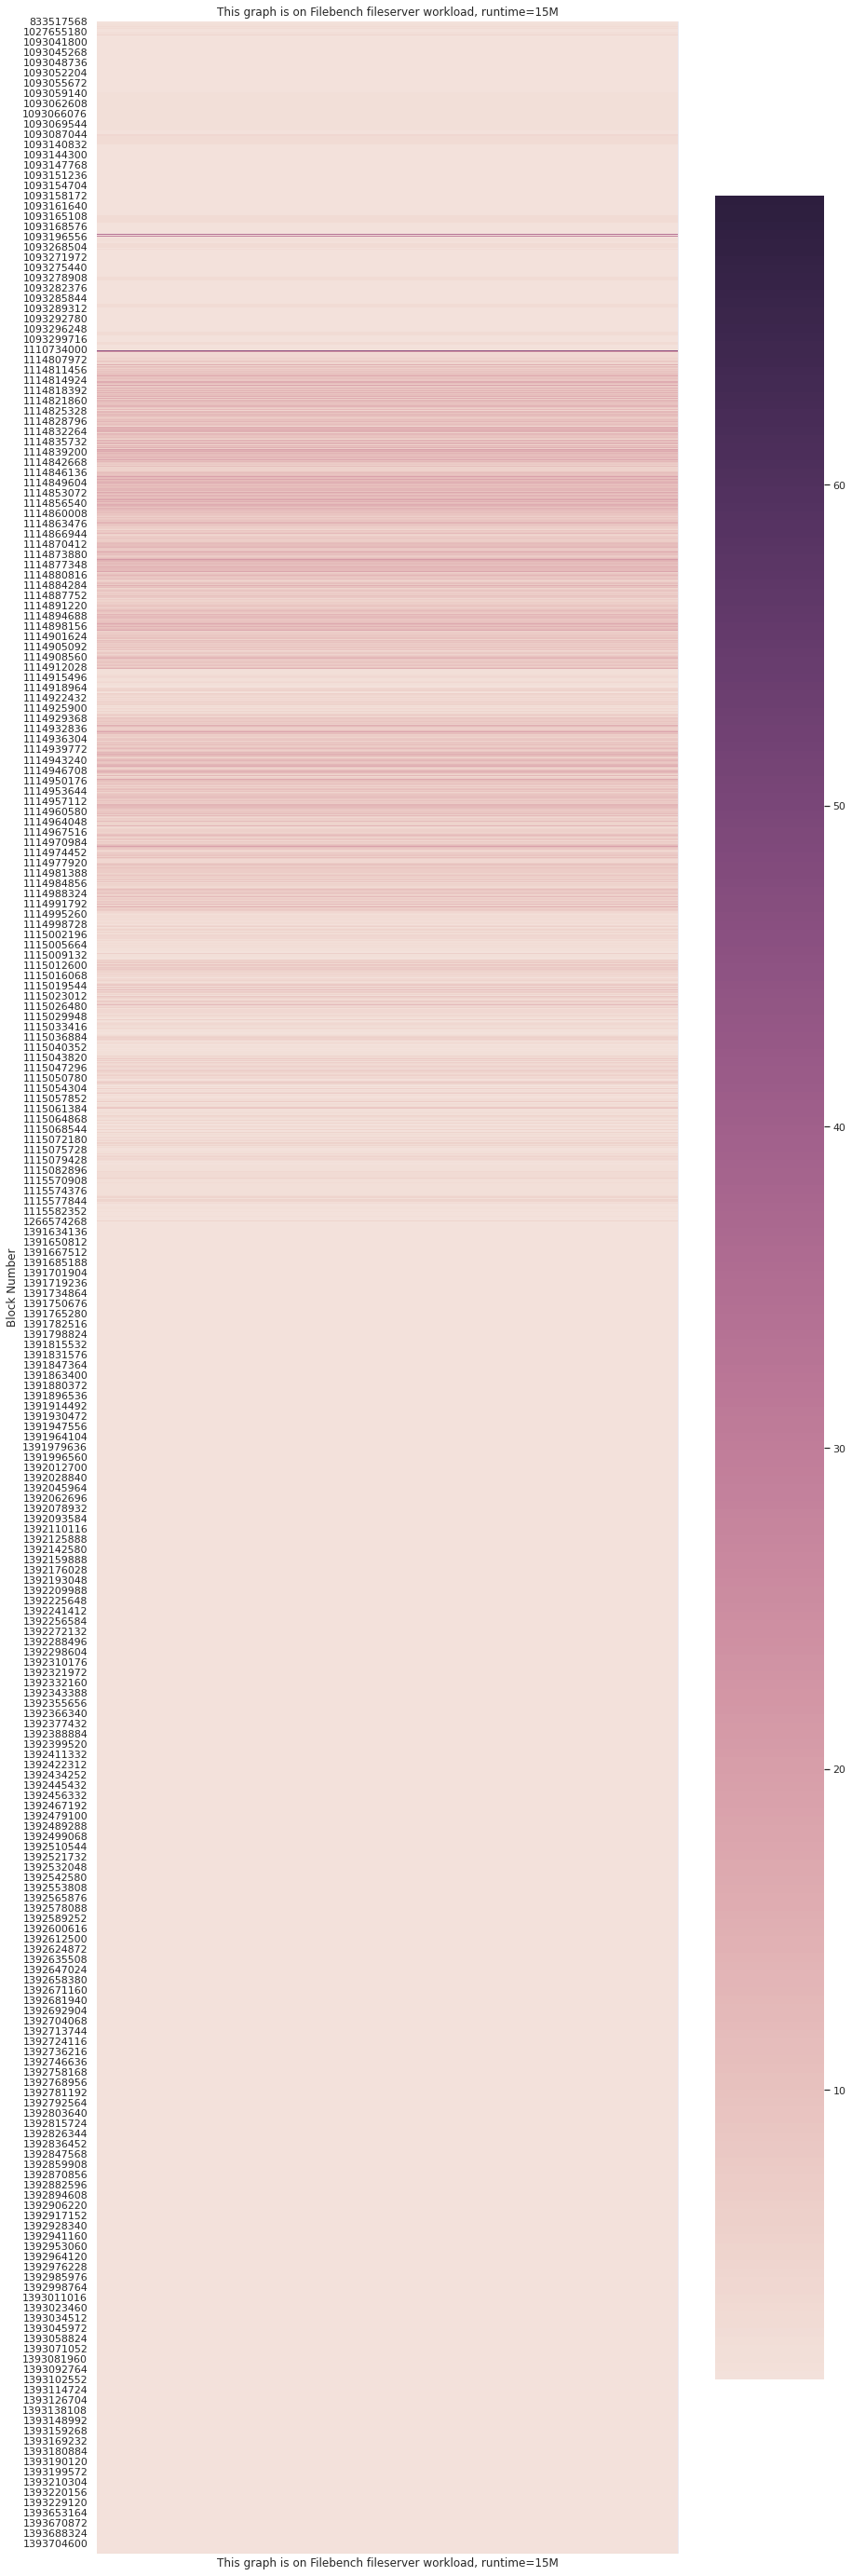

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(14,50)})

cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(sorted_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('This graph is on Filebench fileserver workload, runtime=15M')
plt.ylabel('Block Number')

plt.title('This graph is on Filebench fileserver workload, runtime=15M')
plt.show()

In [14]:
block_range_2000_plus = 0
block_range_1000_2000 = 0
block_range_500_1000 = 0
block_range_100_500 = 0
block_range_50_100 = 0
block_range_10_50 = 0
block_range_2_10 = 0
block_range_1 = 0
block_range_0 = 0




io_range_2000_plus = 0
io_range_1000_2000 = 0
io_range_500_1000 = 0
io_range_100_500 = 0
io_range_50_100 = 0
io_range_10_50 = 0
io_range_2_10 = 0
io_range_1 = 0





list_block_access_desc = sorted(block_counter_dict.values(), reverse=True)

for i in list_block_access_desc:
    if i >= 2000:
        block_range_2000_plus += 1
        io_range_2000_plus += i
        
    elif i >= 1000 and i < 2000:
        block_range_1000_2000 += 1
        io_range_1000_2000 += i
        
    elif i >= 500 and i < 1000:
        block_range_500_1000 += 1
        io_range_500_1000 += i
        
    elif i >= 100 and i < 500:
        block_range_100_500 += 1
        io_range_100_500 += i
        
    elif i >= 50 and i < 100:
        block_range_50_100 += 1
        io_range_50_100 += i
        
    elif i >=10 and i <= 50:
        block_range_10_50 += 1
        io_range_10_50 += i
        
    elif i >=2 and i <= 10:
        block_range_2_10 += 1
        io_range_2_10 += i
        
    elif i == 1:
        block_range_1 += 1
        io_range_1 += i
        
total_number_of_blocks = max(block_counter_dict)
block_range_0 = (total_number_of_blocks - (len(block_counter_dict)))


print("block_range_2000_plus", block_range_2000_plus)
print("block_range_1000_2000", block_range_1000_2000)
print("block_range_500_1000", block_range_500_1000)
print("block_range_100_500", block_range_100_500)
print("block_range_50_100", block_range_50_100)
print("block_range_10_50", block_range_10_50)
print("block_range_2_10", block_range_2_10)
print("block_range_1", block_range_1)
print("block_range_0", block_range_0)

number_of_blocks_total_accessed = block_range_2000_plus + block_range_1000_2000 + block_range_500_1000 + block_range_100_500 + block_range_50_100 + block_range_10_50 + block_range_2_10 + block_range_1
print("sum of all accessed blocks = ", number_of_blocks_total_accessed)



print("\n\n\n")


print("io_range_2000_plus", io_range_2000_plus)
print("io_range_1000_2000", io_range_1000_2000)
print("io_range_500_1000", io_range_500_1000)
print("io_range_100_500", io_range_100_500)
print("io_range_50_100", io_range_50_100)
print("io_range_10_50", io_range_10_50)
print("io_range_2_10", io_range_2_10)
print("io_range_1", io_range_1)

total_IOs_block = io_range_2000_plus + io_range_1000_2000 + io_range_500_1000 + io_range_100_500 + io_range_50_100 + io_range_10_50 + io_range_2_10 + io_range_1
print("sum of all IOs = ", total_IOs_block)

block_range_2000_plus 0
block_range_1000_2000 0
block_range_500_1000 0
block_range_100_500 0
block_range_50_100 24
block_range_10_50 83640
block_range_2_10 225712
block_range_1 547208
block_range_0 1596397047
sum of all accessed blocks =  856584




io_range_2000_plus 0
io_range_1000_2000 0
io_range_500_1000 0
io_range_100_500 0
io_range_50_100 1408
io_range_10_50 1060104
io_range_2_10 1081744
io_range_1 547208
sum of all IOs =  2690464


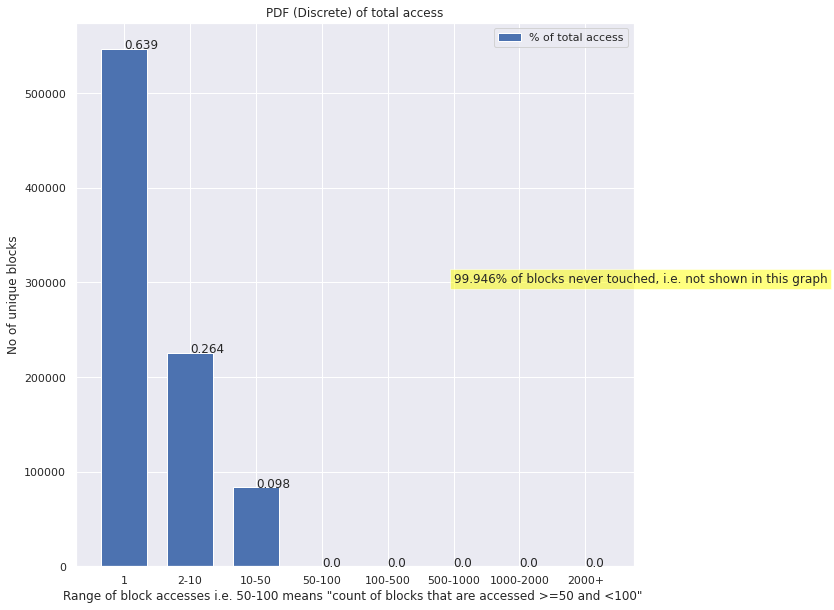

In [15]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(10,10))

x_axis = ["1", "2-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000+"]

y_axis = [block_range_1, block_range_2_10, block_range_10_50,
          block_range_50_100, block_range_100_500, block_range_500_1000,
          block_range_1000_2000, block_range_2000_plus]

pyplot.bar(x_axis, y_axis, width=0.7, label='% of total access')
# pyplot.bar(x_h, host_read_latency, width=0.7, label='Oasis')
# pyplot.xticks([])
pyplot.legend(loc='upper right')
pyplot.title("PDF (Discrete) of total access")
pyplot.ylabel('No of unique blocks')
pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
pyplot.text(5, 300000, "99.946% of blocks never touched, i.e. not shown in this graph", bbox=dict(facecolor='yellow', alpha=0.5))

for i in range(len(x_axis)):
    pyplot.annotate(str(round(y_axis[i]/number_of_blocks_total_accessed, 3)), xy=(x_axis[i], y_axis[i]))



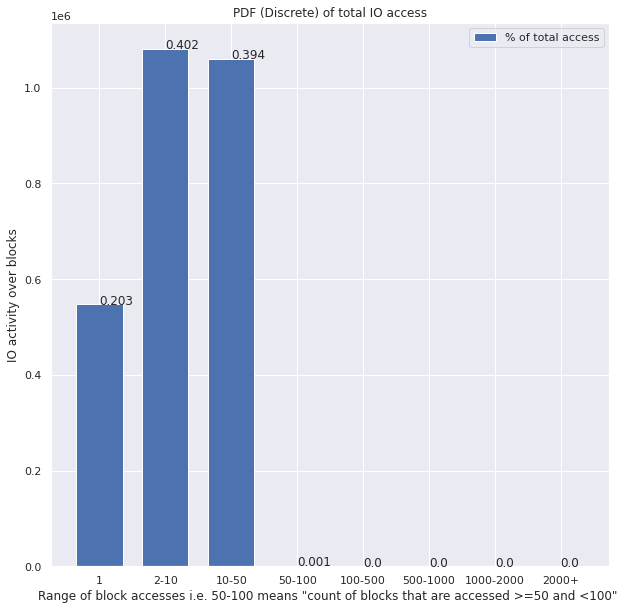

In [16]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(10,10))

x_axis = ["1", "2-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000+"]

y_axis = [io_range_1, io_range_2_10, io_range_10_50,
          io_range_50_100, io_range_100_500, io_range_500_1000,
          io_range_1000_2000, io_range_2000_plus]

pyplot.bar(x_axis, y_axis, width=0.7, label='% of total access')
# pyplot.bar(x_h, host_read_latency, width=0.7, label='Oasis')
# pyplot.xticks([])
pyplot.legend(loc='upper right')
pyplot.title("PDF (Discrete) of total IO access")
pyplot.ylabel('IO activity over blocks')
pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
# pyplot.text(5, 150000, "99.982% of blocks never touched, i.e. not shown in this graph", bbox=dict(facecolor='yellow', alpha=0.5))

for i in range(len(x_axis)):
    pyplot.annotate(str(round(y_axis[i]/total_IOs_block, 3)), xy=(x_axis[i], y_axis[i]))

